In [1]:
import os
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import load_img
from keras.models import load_model

In [3]:
# Extraction du fichier zip
local_zip = 'archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [4]:
"""
    la taille de toutes les images est (128,128) pxl
"""

mask_rep = os.path.join('./Dataset/with_mask')
non_mask_rep = os.path.join('./Dataset/without_mask/')
faux_mask_rep = os.path.join('./Dataset/mask_weared_incorrect/')

print('total image masque : ', len(os.listdir(mask_rep)))
print('total image sans masque : ', len(os.listdir(non_mask_rep)))
print('total image masque incorrecte : ', len(os.listdir(faux_mask_rep)))


total image masque :  2994
total image sans masque :  2994
total image masque incorrecte :  2999


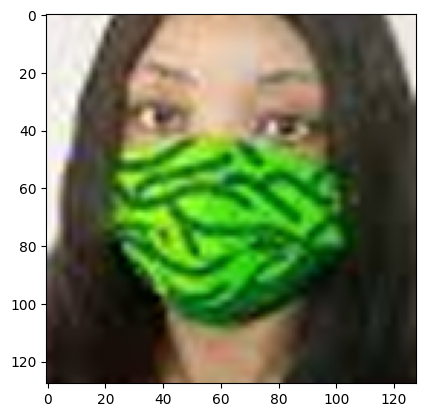

In [5]:
image = mpimg.imread(os.path.join(mask_rep, os.listdir(mask_rep)[676]))
plt.imshow(image)
plt.show()

In [6]:
REP_ENTRAINEMENT = ("Dataset/")

entr_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.5,
    zoom_range=0.5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

entr_dataset = entr_datagen.flow_from_directory(
    REP_ENTRAINEMENT,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=125,
    subset='training'
)

val_dataset = entr_datagen.flow_from_directory(
    REP_ENTRAINEMENT,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=125,
    subset='validation'
)

Found 7192 images belonging to 3 classes.
Found 1795 images belonging to 3 classes.


In [7]:
# ImageDataGenerator --> train+test
# train_test_split --> x_train, y_train, x_val, y_val

In [8]:
# x_train, y_train --> KFold/cross_validation

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),#63

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),#30

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),#14

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),#6

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    entr_dataset,
    epochs=30,
    steps_per_epoch=16,
    validation_data = val_dataset,
    verbose=1,
    validation_steps=5
)

model.save("DetectionMasque.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

c:\Users\PC de MEDUSA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


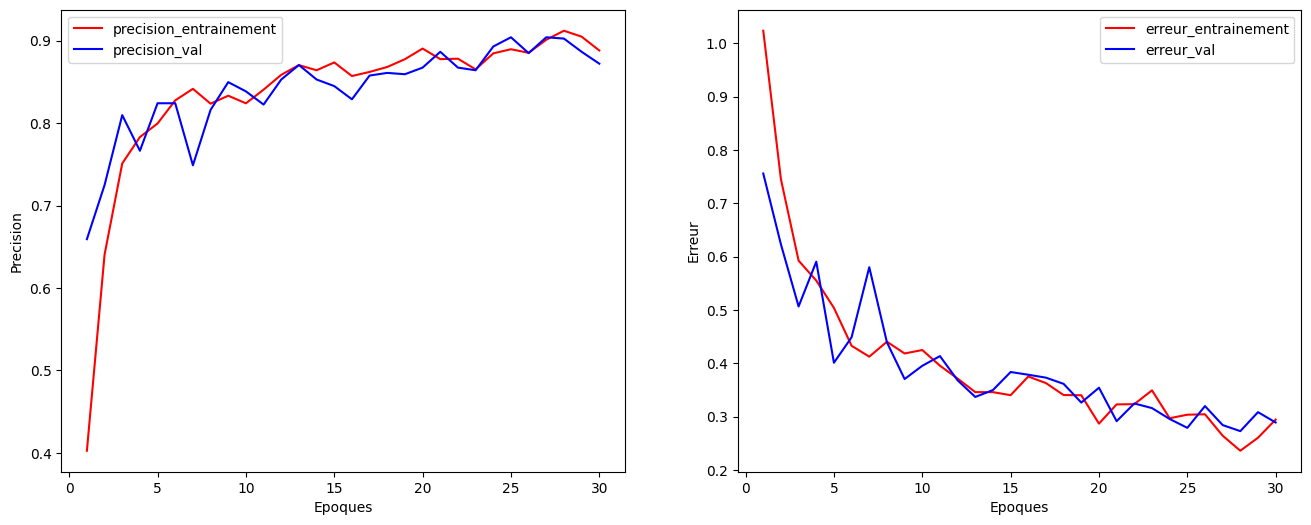

In [10]:
precision = history.history['accuracy']
val_precision = history.history['val_accuracy']
erreur = history.history['loss']
val_erreur = history.history['val_loss']

epoques = range(1, len(precision) + 1)

plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.plot(epoques, precision, 'r', label="precision_entrainement")
plt.plot(epoques, val_precision, 'b', label="precision_val")
plt.xlabel('Epoques')
plt.ylabel('Precision')
plt.legend()

plt.subplot(122)
plt.plot(epoques, erreur, 'r', label="erreur_entrainement")
plt.plot(epoques, val_erreur, 'b', label="erreur_val")
plt.xlabel('Epoques')
plt.ylabel('Erreur')
plt.legend()

plt.show()


In [11]:
model = load_model('DetectionMasque.h5')
dossier = os.listdir('./test/')

for i, nom in enumerate(dossier):
    image = load_img('./test/'+nom, target_size=(128, 128))
    x = np.array(image)
    x = np.expand_dims(x, axis=0)
    image = np.vstack([x])

    classes = model.predict(image)
    if classes[0][0] == 1:
        res = 'masque mis incorrectement'
    elif classes[0][1] == 1:
        res = 'avec masque'
    elif classes[0][2] == 1:
        res = 'sans masque'
    print(nom, res)
    

1/1 [==============================] - 0s 467ms/step
1.jpg avec masque
1/1 [==============================] - 0s 30ms/step
10.jpg sans masque
1/1 [==============================] - 0s 31ms/step
11.jpg sans masque
1/1 [==============================] - 0s 36ms/step
12.jpg sans masque
1/1 [==============================] - 0s 26ms/step
13.jpg sans masque
1/1 [==============================] - 0s 28ms/step
14.jpg sans masque
1/1 [==============================] - 0s 24ms/step
145.jpg sans masque
1/1 [==============================] - 0s 29ms/step
146.jpg sans masque
1/1 [==============================] - 0s 41ms/step
147.jpg sans masque
1/1 [==============================] - 0s 29ms/step
148.jpg sans masque
1/1 [==============================] - 0s 28ms/step
149.jpg sans masque
1/1 [==============================] - 0s 30ms/step
150.jpg sans masque
1/1 [==============================] - 0s 57ms/step
151.jpg sans masque
1/1 [==============================] - 0s 28ms/step
152.jpg sans masqu

### Resultats : le modèle a bien pu détécter les visage qui portent un masque et les visages qui ne le portent pas, mais il a failli de connaitre si le masque était correctement porté ou non.